<a href="https://colab.research.google.com/github/AlinaKruzhkova/University/blob/main/Tasks/%22%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%969_%D0%9F%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D1%8B%D0%B8%CC%86_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B4%D0%BE%D1%81%D1%82%D1%83%D0%BF%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D1%81%D0%BE%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B8%CC%86_%D0%B8%D0%BD%D1%84%D1%80%D0%B0%D1%81%D1%82%D1%80%D1%83%D0%BA%D1%82%D1%83%D1%80%D1%8B_%D1%81_%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%D0%BC_OpenStreetMap_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №9. Пространственный анализ доступности социальной инфраструктуры с использованием OpenStreetMap**

## **Цель работы**

Овладеть методами пространственного анализа городских территорий на основе открытых геоданных: загрузка данных из OpenStreetMap, конструирование пространственных признаков и их визуализация на тепловых картах административных районов и гексагональной H3‑сетки.

## **Введение**

Доступность социальной инфраструктуры (школы, детские сады, поликлиники, общественный транспорт и т.п.) является базовой характеристикой качества городской среды. Современные методы геоанализа позволяют количественно оценивать уровень такой доступности для разных участков города и визуализировать результаты в удобной для интерпретации форме.

В данной практической работе вы выполните полный цикл пространственного анализа: от выбора территории и постановки исследовательской задачи до расчёта интегрального показателя доступности и построения тепловых карт по районам и гексагональной ячейке.

## **Задание**

Провести пространственное исследование уровня доступности социальной инфраструктуры для жителей выбранной городской территории, используя данные OpenStreetMap, и визуализировать результаты:

- на карте административных районов;
- на гексагональной H3‑сетке.

---

## **Порядок выполнения работы**

### **Часть 1. Подготовка данных и постановка задачи**

1. **Выбор территории и фокуса исследования**

   - Выберите город и область интереса (ROI) для анализа:
     - это может быть весь город или его часть (например, центральные районы, спальный район, новая застройка).
   - Определите фокус исследования:
     - например:
       - доступность школ и детских садов;
       - доступность поликлиник и больниц;
       - комплексная доступность нескольких типов объектов (школы + сады + поликлиники + остановки ОТ).
   - Кратко обоснуйте выбор:
     - почему вы выбрали именно эту территорию;
     - почему выбранный фокус социальной инфраструктуры важен и интересен для анализа.

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
%%capture
!pip install scikit-learn geopandas h3pandas h3~=3.0 leafmap mapclassify matplotlib streamlit osmnx openrouteservice polyline -q

In [ ]:
# Библиотеки
import geopandas as gpd
import pandas as pd
import numpy as np
import h3
import h3pandas
import leafmap
from shapely.geometry import box
from sklearn.preprocessing import MinMaxScaler

import osmnx as ox
import matplotlib.pyplot as plt

In [ ]:
m = leafmap.Map(center=[55.751244, 37.618423], zoom=10, draw_control=True)
m

Map(center=[55.751244, 37.618423], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [ ]:
m.user_roi_bounds()

In [ ]:
# Получаем координаты региона интереса
bbox = m.user_roi_bounds()

if bbox:
    print(f"Пользователь выбрал bounding box: {bbox}")
    gdf = None
else:
    print("Пользователь не указал зону интереса. Используем Басманный район.")

    gdf = ox.geocode_to_gdf("Басманный, Москва")

    # Получение прямоугольных границ
    minx, miny, maxx, maxy = gdf.total_bounds
    bbox = (minx, miny, maxx, maxy)
    bbox = tuple(float(x) for x in bbox)

    print(f"Выбран Басманный район: {bbox}")
    m.add_gdf(gdf, layer_name="Bounding Box")

m

Пользователь не указал зону интереса. Используем Басманный район.
Выбран Басманный район: (37.6278676, 55.7507488, 37.7135295, 55.782047)


Map(bottom=328086.0, center=[55.756022716560636, 37.67555132111302], controls=(ZoomControl(options=['position'…

**ВАШ ОТВЕТ**

Для анализа был выбран Басманный район города Москвы, а в качестве фокуса исследования — доступность банков, бизнес-центров и ресторанов. Такой выбор обоснован их ролью в формировании экономической и сервисной инфраструктуры: банки для финансовых операций, бизнес-центры для работы и рестораны для повседневного питания.

В Басманном районе эти объекты распределены неравномерно — центр обеспечен хорошо, ближайшие микрорайоны испытывают дефицит из-за высокой плотности жилой застройки и удалённости микрорайонов.

Анализ выявит зоны с недостаточным покрытием и предложит меры по улучшению доступности для жителей и бизнеса.

2. **Определение признаков доступности**

   - Сформулируйте **не менее 5 признаков**, которые, по вашему мнению, характеризуют доступность социальной инфраструктуры для жителей. Примеры признаков:
     - количество объектов нужного типа в шаговой доступности;
     - средняя удалённость до ближайшего объекта;
     - наличие альтернативных видов инфраструктуры (например, частные и государственные школы);
     - транспортная доступность (наличие остановок общественного транспорта поблизости);
     - обеспеченность зелёными зонами рядом с социальной инфраструктурой (парки возле школ и т.п.).
   - Для каждого признака определите, **какими тегами OpenStreetMap** его можно описать. Примеры тегов:
     - `amenity=school`, `amenity=kindergarten`, `amenity=clinic`, `amenity=hospital`;
     - `highway=bus_stop`, `railway=subway_entrance`;
     - `leisure=park`, `leisure=pitch`;
     - границы районов: `boundary=administrative`, `admin_level=*`.
   - Составьте **таблицу соответствия**:

     | признак                     | Описание признака                             | OSM‑теги / атрибуты                       |
     |----------------------------|----------------------------------------------|-------------------------------------------|
     | Кол-во школ в шаговой доступности | Школы в радиусе 800 м от ячейки/района | `amenity=school`                          |
     | Наличие детских садов      | Детсады в радиусе 600 м                     | `amenity=kindergarten`                    |
     | Транспортная доступность   | Остановки ОТ в радиусе 400 м                | `highway=bus_stop`, `railway=tram_stop`   |
     | Близость метро             | Минимальное расстояние до метро             | `railway=subway_entrance`                 |
     | Наличие зелёных зон        | Площадь парков в радиусе 800 м              | `leisure=park`                            |


**ВАША ТАБЛИЦА**

In [ ]:
data = {
    "Признак": [
        "Кол-во банков в шаговой доступности",
        "Кол-во бизнес-центров рядом",
        "Кол-во ресторанов в радиусе доступности",
        "Среднее расстояние до ближайшего банка",
        "Среднее расстояние до бизнес-центра",
        "Среднее расстояние до ресторана",
        "Плотность коммерческой инфраструктуры",
        "Обеспеченность офисными пространствами"
    ],
    "Описание признака": [
        "Количество банков/банкоматов в радиусе 500–800 м",
        "Количество бизнес-центров/офисов в радиусе 800–1000 м",
        "Количество ресторанов/кафе в радиусе 500–800 м",
        "Минимальное/среднее расстояние до ближайшего банка",
        "Минимальное/среднее расстояние до бизнес-центра",
        "Минимальное/среднее расстояние до ресторана",
        "Общее количество коммерческих объектов на ячейку",
        "Площадь офисных помещений в радиусе 1000 м"
    ],
    "OSM-теги / атрибуты": [
        "amenity=bank, atm",
        "office=*, building=commercial, commercial=yes",
        "amenity=restaurant, cafe, fast_food, bar, pub",
        "amenity=bank, atm",
        "office=*, building=commercial",
        "amenity=restaurant, cafe, fast_food",
        "amenity=bank + office=* + amenity=restaurant",
        "office=*; building=office, commercial"
    ]
}

df_features = pd.DataFrame(data)
df_features

,Признак,Описание признака,OSM-теги / атрибуты
0,Кол-во банков в шаговой доступности,Количество банков/банкоматов в радиусе 500–800 м,"amenity=bank, atm"
1,Кол-во бизнес-центров рядом,Количество бизнес-центров/офисов в радиусе 800...,"office=*, building=commercial, commercial=yes"
2,Кол-во ресторанов в радиусе доступности,Количество ресторанов/кафе в радиусе 500–800 м,"amenity=restaurant, cafe, fast_food, bar, pub"
3,Среднее расстояние до ближайшего банка,Минимальное/среднее расстояние до ближайшего б...,"amenity=bank, atm"
4,Среднее расстояние до бизнес-центра,Минимальное/среднее расстояние до бизнес-центра,"office=*, building=commercial"
5,Среднее расстояние до ресторана,Минимальное/среднее расстояние до ресторана,"amenity=restaurant, cafe, fast_food"
6,Плотность коммерческой инфраструктуры,Общее количество коммерческих объектов на ячейку,amenity=bank + office=* + amenity=restaurant
7,Обеспеченность офисными пространствами,Площадь офисных помещений в радиусе 1000 м,"office=*; building=office, commercial"





3. **Сбор исходных данных из OpenStreetMap**

   - Настройте необходимые библиотеки (по аналогии с примером):  
     `osmnx`, `geopandas`, `h3`, `h3pandas`, `leafmap`, `shapely`, `pandas`, `numpy` и др.
   - С помощью интерактивной карты (`leafmap.Map` и инструмент рисования) определите **bounding box** или полигон области интереса.
   - Загрузите из OSM с помощью `osmnx.features_from_bbox()` (или аналогичных функций):
     - объекты социальной инфраструктуры, соответствующие вашим признакам;
     - слои, отражающие административные границы районов (или муниципальных округов).

   - Приведите все пространственные слои к единой системе координат (например, `EPSG:3857` для метрических расчётов).



In [ ]:
import osmnx as ox
import warnings
import geopandas as gpd

# Функция загрузки данных из OSM
def load_osm_data(bbox):
    west, south, east, north = bbox  # bbox = (west, south, east, north)

    tags = {
        # Банки и банкоматы
        'banks': {
            'amenity': ['bank', 'atm']
        },

        # Бизнес-центры и офисы
        'business': {
            'office': ['company', 'yes'],
            'building': ['office', 'commercial']
        },

        # Рестораны, кафе, бары
        'food': {
            'amenity': ['restaurant', 'cafe', 'fast_food', 'bar', 'pub']
        }
    }

    # Загрузка данных с обработкой исключений
    data = {}
    for key, tag in tags.items():
        print(f"Загрузка {key}...")
        try:
            gdf = ox.features_from_bbox((west, south, east, north), tags=tag)
            data[key] = gdf
        except:
            print(f"Нет данных для {key} в заданном регионе. Создаём пустой GeoDataFrame.")
            # Создаём пустой GeoDataFrame с колонкой 'geometry' и устанавливаем CRS
            data[key] = gpd.GeoDataFrame(columns=['geometry'], crs="EPSG:4326")

    return data

# print(bbox)
data = load_osm_data(bbox)

# Приводим данные к нужному CRS
crs_proj = "EPSG:3857"
for key in data.keys():
    # Проверяем, что GeoDataFrame не пустой
    if not data[key].empty and 'geometry' in data[key].columns:
        data[key] = data[key].to_crs(crs_proj)
    else:
        # Если пустой, создаём пустой GeoDataFrame с нужным CRS и колонкой 'geometry'
        data[key] = gpd.GeoDataFrame(columns=['geometry'], crs=crs_proj)

Загрузка banks...
Загрузка business...
Загрузка food...


---

### **Часть 2. Пространственное агрегирование и инженерия признаков**

1. **Построение гексагональной H3‑сетki**

   - Определите подходящее **разрешение (resolution)** H3‑сетки для вашей территории:
     - маленькое значение (5–7) — крупные ячейки для больших территорий;
     - большое значение (8–10 и выше) — более детальный анализ на уровне кварталов/микрорайонов.
   - Обоснуйте ваш выбор resolution с точки зрения:
     - размера города или ROI;
     - характера объектов (шаговая доступность, плотность застройки);
     - удобства визуализации и интерпретации.
   - Сгенерируйте H3‑индексы, покрывающие выбранный полигон (через `h3.polyfill_geojson`), и создайте `GeoDataFrame` с геометриями ячеек.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

crs_proj = "EPSG:3857"

# Функция анализа для каждой H3-ячейки (банки, бизнес-центры, рестораны)
def analyze_h3_cell(geom):
    # Буферы в метрах ( в CRS EPSG:3857)
    buffer_800m = geom.buffer(800)    # шаговая доступность 10 минут
    buffer_1000m = geom.buffer(1000)  # для бизнес-центров

    # Кол-во банков в радиусе 800 м
    num_banks = data['banks'][data['banks'].geometry.intersects(buffer_800m)].shape[0]

    # Кол-во бизнес-центров в радиусе 1000 м
    num_business = data['business'][data['business'].geometry.intersects(buffer_1000m)].shape[0]

    # Кол-во ресторанов в радиусе 800 м
    num_food = data['food'][data['food'].geometry.intersects(buffer_800m)].shape[0]

    return num_banks, num_business, num_food

resolution = 9  # resolution H3 для Басманного района

from shapely.geometry import box
# bbox = (west, south, east, north) в WGS84 (EPSG:4326)
# Создаем полигон bbox и переводим в метрическую проекцию
bbox_polygon = box(*bbox)  # в CRS EPSG:4326
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:4326").to_crs(crs_proj)

# Для polyfill нужен geojson в широта/долгота; используем исходный bbox_polygon (EPSG:4326)
h3_indexes = list(h3.polyfill_geojson(bbox_polygon.__geo_interface__, resolution))

# Создаем GeoDataFrame с H3-ячейками (сначала в WGS84, затем в метры)
h3_geometries = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in h3_indexes]
h3_gdf = gpd.GeoDataFrame({'h3_index': h3_indexes, 'geometry': h3_geometries}, crs="EPSG:4326").to_crs(crs_proj)

# Применяем анализ к каждой H3-ячейке
h3_gdf[['num_banks', 'num_business', 'num_food']] = h3_gdf.geometry.apply(
    lambda geom: pd.Series(analyze_h3_cell(geom))
)

# Список колонок для нормализации
columns_to_normalize = ['num_banks', 'num_business', 'num_food']

# Нормализация признаков в диапазон [0, 1]
h3_gdf[columns_to_normalize] = scaler.fit_transform(h3_gdf[columns_to_normalize])

# Итоговый интегральный индекс
h3_gdf['index_score'] = h3_gdf[columns_to_normalize].sum(axis=1)

h3_gdf.head()


,h3_index,geometry,num_banks,num_business,num_food,index_score
0,8911aa63643ffff,"POLYGON ((4191446.663 7512840.673, 4191712.808...",0.744681,0.516717,0.372832,1.634231
1,8911aa63647ffff,"POLYGON ((4191795.331 7513350.449, 4192061.49 ...",0.659574,0.434650,0.364162,1.458387
2,8911aa789c3ffff,"POLYGON ((4195662.547 7509136.949, 4195928.546...",0.000000,0.006079,0.017341,0.023420
3,8911aa78d97ffff,"POLYGON ((4191322.942 7511762.656, 4191589.052...",0.446809,0.580547,0.349711,1.377067
4,8911aa789d3ffff,"POLYGON ((4195089.122 7509195.868, 4195355.126...",0.021277,0.063830,0.000000,0.085106


Почему выбрала resolution=9 для Басманного района?

Басманный район - это небольшая центральная часть Москвы (~8.5 км²). **Resolution 9** создаёт ячейки размером ~150-200 м, что идеально покрывает район 50-70 ячейками, это оптимальное количество для анализа.

Характер объектов и шаговая доступность:

- Банки и рестораны оцениваются в радиусе 800 м (~10 мин пешком);

- Бизнес-центры оцениваются в радиусе 1000 м

- Размер ячейки 9 соответствует этим расстояниям и плотной центральной застройке, где объекты группируются по кварталам​

Визуализация и интерпретация:

- Карта не перегружена (не 100500 мелких ячеек как при  resolution=10)

- Легко интерпретировать градиенты обеспеченности инфраструктурой на уровне микрорайонов

2. **Агрегирование по административным районам**

   - Подготовьте слой районов (например, `admin_level=8`):
     - при необходимости отфильтруйте только нужный уровень административного деления.
   - Для каждого района рассчитайте показатели, связанные с выбранными типами инфраструктуры. Примеры:
     - количество школ/детсадов/поликлиник внутри района;
     - плотность объектов (количество на км²);
     - суммарная площадь парков;
     - количество остановок ОТ.
   - Добавьте эти признаки в таблицу районов.

In [ ]:
crs_proj = "EPSG:3857"

# Басманный район как админ. полигон
neigh_gdf = ox.geocode_to_gdf("Басманный район, Москва").to_crs(crs_proj)

# Считаем площадь района
neigh_gdf["area_m2"] = neigh_gdf.geometry.area
neigh_gdf["area_km2"] = neigh_gdf["area_m2"] / 1e6

# Берём первую (и единственную) геометрию района
neigh_geom = neigh_gdf.geometry.iloc[0]

# Банки
banks_gdf = data["banks"].to_crs(crs_proj)
num_banks = banks_gdf[banks_gdf.geometry.within(neigh_geom)].shape[0]

# Бизнес-центры
business_gdf = data["business"].to_crs(crs_proj)
num_business = business_gdf[business_gdf.geometry.within(neigh_geom)].shape[0]

# Рестораны / кафе
food_gdf = data["food"].to_crs(crs_proj)
num_food = food_gdf[food_gdf.geometry.within(neigh_geom)].shape[0]

# Записываем всё в атрибуты района
neigh_gdf["num_banks"] = num_banks
neigh_gdf["num_business"] = num_business
neigh_gdf["num_food"] = num_food

# Плотности (объектов на кв. км)
neigh_gdf["banks_density"] = neigh_gdf["num_banks"] / neigh_gdf["area_km2"]
neigh_gdf["business_density"] = neigh_gdf["num_business"] / neigh_gdf["area_km2"]
neigh_gdf["food_density"] = neigh_gdf["num_food"] / neigh_gdf["area_km2"]

neigh_gdf

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,...,name,display_name,area_m2,area_km2,num_banks,num_business,num_food,banks_density,business_density,food_density
0,"POLYGON ((4188715.061 7510691.674, 4188731.748...",37.627868,55.750749,37.713529,55.782047,181240190,relation,2162195,55.767281,37.669773,...,Basmanny District,"Basmanny District, Moscow, Central Federal Dis...",2.648604e+07,26.486044,111,780,808,4.190886,29.449472,30.506633


In [ ]:
neigh_gdf.to_crs("EPSG:4326").explore(column="banks_density", cmap="spring", legend=True)

3. **Инженерия пространственных признаков для H3‑ячеек**

   - Определите радиусы (в метрах) для анализа **окружения ячейки**:
     - например: ближний радиус 400–600 м, средний радиус 800–1200 м.
   - Для каждой H3‑ячейки рассчитайте **не менее 10 пространственных признаков**, например:
     - количество школ в ближнем радиусе;
     - количество детсадов в ближнем и среднем радиусе;
     - количество поликлиник/больниц в среднем радиусе;
     - суммарная площадь парков в ближнем радиусе;
     - количество остановок общественного транспорта в ближнем радиусе;
     - расстояние до ближайшей школы;
     - расстояние до ближайшей поликлиники;
     - расстояние до ближайшей станции метро или ж/д;
     - плотность объектов социальной инфраструктуры (общее число объектов на площадь буфера);
     - отношение количества социальных объектов к количеству зданий (как прокси обеспеченности).
   - **Дополнительное задание**: придумайте и реализуйте **не менее 2 новых признаков**, которых не было в теоретическом материале и примере, например:
     - индекс смешанности инфраструктуры (сколько разных типов объектов есть в радиусе);
     - доля зелёных зон в буфере относительно общей площади буфера;
     - средневзвешенное расстояние до всех школ/садов (а не только ближайшего).

In [ ]:
import numpy as np

# Радиусы в метрах
r_near = 400   # ближний радиус (~5 мин пешком)
r_mid  = 800   # средний радиус (~10 мин пешком)
r_far  = 1000  # дальний радиус (для бизнес-центров)

# Вычисляем геометрии (в проекции EPSG:3857)
banks_pts = data["banks"].geometry
business_pts = data["business"].geometry
food_pts = data["food"].geometry

def analyze_h3_cell(geom):
    """
    Возвращает 12+ признаков для H3-ячейки Басманного района:
    banks_near/mid, business_far, food_near/mid, densities, distances,
    mixed_index, business_food_ratio, avg_dist_food
    """
    # Буферы в метрах
    buf_near = geom.buffer(r_near)
    buf_mid = geom.buffer(r_mid)
    buf_far = geom.buffer(r_far)

    # Площадь буфера для плотностей
    area_buf_near = buf_near.area if not buf_near.is_empty else np.nan
    area_buf_mid = buf_mid.area if not buf_mid.is_empty else np.nan

    # КОЛИЧЕСТВА ОБЪЕКТОВ

    # Банки: ближний и средний радиус
    banks_near = banks_pts.within(buf_near).sum() if not data["banks"].empty else 0
    banks_mid = banks_pts.within(buf_mid).sum() if not data["banks"].empty else 0

    # Бизнес-центры: дальний радиус (офисы дальше)
    business_far = business_pts.within(buf_far).sum() if not data["business"].empty else 0

    # Рестораны: ближний и средний радиус
    food_near = food_pts.within(buf_near).sum() if not data["food"].empty else 0
    food_mid = food_pts.within(buf_mid).sum() if not data["food"].empty else 0

    # ПЛОТНОСТИ
    total_near = banks_near + food_near
    total_mid = banks_mid + food_near + business_far

    infra_density_near = total_near / area_buf_near if area_buf_near and area_buf_near > 0 else np.nan
    infra_density_mid = total_mid / area_buf_mid if area_buf_mid and area_buf_mid > 0 else np.nan

    # РАССТОЯНИЯ ДО БЛИЖАЙШИХ ОБЪЕКТОВ
    centroid = geom.centroid

    dist_bank_min = banks_pts.distance(centroid).min() if not data["banks"].empty else np.nan
    dist_business_min = business_pts.distance(centroid).min() if not data["business"].empty else np.nan
    dist_food_min = food_pts.distance(centroid).min() if not data["food"].empty else np.nan

    # НОВЫЕ ПРИЗНАКИ

    # 1. ИНДЕКС БИЗНЕС-ОРИЕНТИРОВАННОСТИ (bank+office/food)
    business_orientation = (banks_mid + business_far) / (food_mid + 1) if food_mid > 0 else 0

    # 2. КЛАСТЕРИЗАЦИЯ БАНКОВ (если >= 2 банка рядом, -> признак финансового узла)
    banks_clustered = 1 if banks_near >= 2 else 0

    # 3. БАЛАНС РАБОТА/ОТДЫХ (соотношение офисов к ресторанам в среднем радиусе)
    work_leisure_balance = abs(business_far - food_mid) / (business_far + food_mid + 1)

    return (
        banks_near, banks_mid, business_far, food_near, food_mid,
        infra_density_near, infra_density_mid,
        dist_bank_min, dist_business_min, dist_food_min,
        business_orientation, banks_clustered, work_leisure_balance
    )

# Список признаков
feature_names = [
    "banks_near", "banks_mid", "business_far", "food_near", "food_mid",
    "infra_density_near", "infra_density_mid",
    "dist_bank_min", "dist_business_min", "dist_food_min",
    "business_orientation", "banks_clustered", "work_leisure_balance"
]

# Применяем функцию ко всем H3-ячейкам
h3_features = h3_gdf.geometry.apply(
    lambda g: pd.Series(analyze_h3_cell(g), index=feature_names)
)

# Приклеиваем признаки к h3_gdf
h3_gdf = pd.concat([h3_gdf, h3_features], axis=1)

h3_gdf.head()

,h3_index,geometry,num_banks,num_business,num_food,index_score,banks_near,banks_mid,business_far,food_near,...,food_near,food_mid,infra_density_near,infra_density_mid,dist_bank_min,dist_business_min,dist_food_min,business_orientation,banks_clustered,work_leisure_balance
0,8911aa63643ffff,"POLYGON ((4191446.663 7512840.673, 4191712.808...",0.744681,0.516717,0.372832,1.634231,13.0,34.0,166.0,64.0,...,64.0,131.0,0.000047,0.000066,399.911369,1.816488,61.536031,1.515152,1.0,0.117450
1,8911aa63647ffff,"POLYGON ((4191795.331 7513350.449, 4192061.49 ...",0.659574,0.434650,0.364162,1.458387,19.0,31.0,129.0,67.0,...,67.0,128.0,0.000052,0.000057,183.225112,294.130904,175.054692,1.240310,1.0,0.003876
2,8911aa789c3ffff,"POLYGON ((4195662.547 7509136.949, 4195928.546...",0.000000,0.006079,0.017341,0.023420,0.0,0.0,7.0,3.0,...,3.0,8.0,0.000002,0.000003,1175.006312,695.206156,561.228778,0.777778,0.0,0.062500
3,8911aa78d97ffff,"POLYGON ((4191322.942 7511762.656, 4191589.052...",0.446809,0.580547,0.349711,1.377067,8.0,21.0,180.0,36.0,...,36.0,122.0,0.000027,0.000059,289.047033,208.713689,130.095315,1.634146,1.0,0.191419
4,8911aa789d3ffff,"POLYGON ((4195089.122 7509195.868, 4195355.126...",0.021277,0.063830,0.000000,0.085106,0.0,1.0,25.0,0.0,...,0.0,2.0,0.000000,0.000007,1072.877721,449.620701,954.461287,8.666667,0.0,0.821429








4. **Базовый анализ признаков**

   - Рассчитайте простые статистики для признаков районов и H3‑ячеек:
     - минимум, максимум, среднее, медиана, квартилли, стандартное отклонение.
   - Исследуйте взаимные **корреляции** между признаками:
     - выделите группы сильно коррелированных признаков;
     - сделайте промежуточные выводы (например, «в районах с большим числом школ больше и остановок ОТ»).
   - Обнаружьте и обработайте:
     - **пропущенные значения** (NaN);
     - **выбросы** (аномально большие или малые значения признаков).
   - Оформите принятые решения (удаление, заполнение, логарифмирование и т.п.).



БАЗОВЫЙ АНАЛИЗ ДЛЯ: H3 Features Басманный район

Описательные статистики:



,count,mean,std,min,25%,50%,75%,max
banks_near,188.0,6.840426,6.885314,0.000000,1.000000,4.000000,11.000000,35.000000
banks_mid,188.0,15.026596,12.252440,0.000000,4.000000,13.000000,24.000000,47.000000
business_far,188.0,106.292553,77.947909,3.000000,38.750000,100.000000,151.000000,305.000000
food_near,188.0,35.404255,34.657783,0.000000,7.000000,23.000000,52.000000,160.000000
food_mid,188.0,80.473404,68.039736,2.000000,26.250000,60.000000,119.250000,348.000000
infra_density_near,188.0,0.000026,0.000024,0.000000,0.000005,0.000018,0.000040,0.000105
infra_density_mid,188.0,0.000039,0.000029,0.000002,0.000012,0.000035,0.000058,0.000118
dist_bank_min,188.0,412.662093,287.708159,4.934835,182.927006,346.135743,594.147929,1239.965435
dist_business_min,188.0,171.464097,176.954132,0.000000,39.121855,117.703122,237.219053,833.016672
dist_food_min,188.0,222.842974,178.555764,6.689413,95.946448,174.259695,288.913141,954.461287



Корреляционная матрица:



,banks_near,banks_mid,business_far,food_near,food_mid,infra_density_near,infra_density_mid,dist_bank_min,dist_business_min,dist_food_min,business_orientation,banks_clustered,work_leisure_balance
banks_near,1.00,0.88,0.58,0.58,0.55,0.69,0.66,-0.65,-0.35,-0.40,-0.13,0.59,-0.39
banks_mid,0.88,1.00,0.73,0.63,0.70,0.71,0.78,-0.62,-0.41,-0.45,-0.17,0.59,-0.48
business_far,0.58,0.73,1.00,0.76,0.86,0.78,0.98,-0.51,-0.54,-0.47,-0.03,0.52,-0.37
food_near,0.58,0.63,0.76,1.00,0.91,0.99,0.88,-0.46,-0.43,-0.51,-0.31,0.44,-0.54
food_mid,0.55,0.70,0.86,0.91,1.00,0.91,0.93,-0.47,-0.46,-0.50,-0.33,0.49,-0.60
infra_density_near,0.69,0.71,0.78,0.99,0.91,1.00,0.89,-0.53,-0.45,-0.52,-0.30,0.49,-0.55
infra_density_mid,0.66,0.78,0.98,0.88,0.93,0.89,1.00,-0.55,-0.53,-0.52,-0.13,0.54,-0.46
dist_bank_min,-0.65,-0.62,-0.51,-0.46,-0.47,-0.53,-0.55,1.00,0.46,0.48,0.12,-0.67,0.27
dist_business_min,-0.35,-0.41,-0.54,-0.43,-0.46,-0.45,-0.53,0.46,1.00,0.51,0.04,-0.35,0.15
dist_food_min,-0.40,-0.45,-0.47,-0.51,-0.50,-0.52,-0.52,0.48,0.51,1.00,0.32,-0.39,0.33


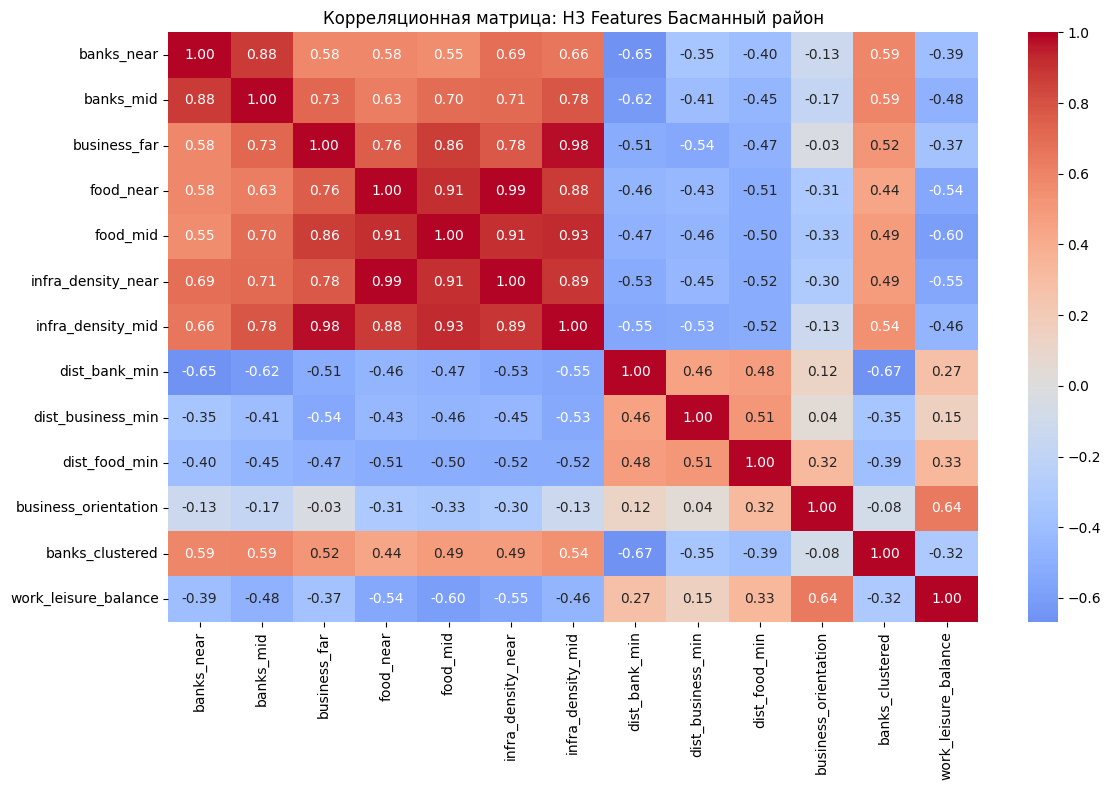


Пропущенные значения (NaN):



,0



Выбросы по IQR:

banks_near: 3 выбросов (1.6%)
banks_mid: 0 выбросов (0.0%)
business_far: 0 выбросов (0.0%)
food_near: 7 выбросов (3.7%)
food_mid: 4 выбросов (2.1%)
infra_density_near: 3 выбросов (1.6%)
infra_density_mid: 0 выбросов (0.0%)
dist_bank_min: 1 выбросов (0.5%)
dist_business_min: 12 выбросов (6.4%)
dist_food_min: 9 выбросов (4.8%)
business_orientation: 8 выбросов (4.3%)
banks_clustered: 0 выбросов (0.0%)
work_leisure_balance: 0 выбросов (0.0%)

ПРОМЕЖУТОЧНЫЕ ВЫВОДЫ:
• banks_near ↔ banks_mid: 0.88
• banks_mid ↔ business_far: 0.73
• banks_mid ↔ infra_density_near: 0.71
• banks_mid ↔ infra_density_mid: 0.78
• business_far ↔ food_near: 0.76
• business_far ↔ food_mid: 0.86
• business_far ↔ infra_density_near: 0.78
• business_far ↔ infra_density_mid: 0.98
• food_near ↔ food_mid: 0.91
• food_near ↔ infra_density_near: 0.99
• food_near ↔ infra_density_mid: 0.88
• food_mid ↔ infra_density_near: 0.91
• food_mid ↔ infra_density_mid: 0.93
• infra_density_near ↔ infra_density_mid: 0.89


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_features(df, feature_cols, name="Dataset"):
    print("="*80)
    print(f"Базовый анализ для: {name}")
    print("="*80)

    # Очищаем дубликаты колонок перед анализом
    df_clean = df[feature_cols].copy()
    df_clean.columns = [f"{col}_{i}" if df_clean.columns.duplicated(0).any() else col for i, col in enumerate(df_clean.columns)]

    # 1. Статистики
    print("\nОписательные статистики:\n")
    display(df_clean.describe().T)

    # 2. Корреляции
    print("\nКорреляционная матрица:\n")
    corr = df_clean.corr()
    display(corr.round(2))

    # Тепловая карта
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", center=0)
    plt.title(f"Корреляционная матрица: {name}")
    plt.tight_layout()
    plt.show()

    # 3. Пропущенные значения
    print("\nПропущенные значения (NaN):\n")
    missing = df_clean.isna().sum()
    display(missing[missing > 0])

    # 4. Выбросы по IQR
    print("\nВыбросы по IQR:\n")
    for col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        outliers = df_clean[(df_clean[col] < low) | (df_clean[col] > high)][col]
        print(f"{col}: {len(outliers)} выбросов ({len(outliers)/len(df_clean)*100:.1f}%)")

    # Выводы по корреляциям
    print("\nПРОМЕЖУТОЧНЫЕ ВЫВОДЫ:")
    high_corr = [(corr.columns[i], corr.columns[j], corr.iloc[i,j])
                for i in range(len(corr)) for j in range(i+1, len(corr))
                if abs(corr.iloc[i,j]) > 0.7]

    if high_corr:
        for pair in high_corr:
            print(f"• {pair[0]} ↔ {pair[1]}: {pair[2]:.2f}")
    else:
        print("• Сильных корреляций (>0.7) нет")


h3_gdf = h3_gdf.loc[:,~h3_gdf.columns.duplicated()]  # Перед вызовом функции удаляем дублирующиеся колонки

# Признаки
h3_features = [
    "banks_near", "banks_mid", "business_far", "food_near", "food_mid",
    "infra_density_near", "infra_density_mid",
    "dist_bank_min", "dist_business_min", "dist_food_min",
    "business_orientation", "banks_clustered", "work_leisure_balance"
]

analyze_features(h3_gdf, h3_features, name="H3 Features Басманный район")

---

### **Часть 3. Оценка уровня доступности и типология территорий**

1. **Разработка интегрального индекса доступности**

   - Выберите подмножество наиболее важных признаков (по вашему мнению) для оценки доступности:
     - отдельно для районов;
     - отдельно для H3‑ячеек.
   - Нормализуйте выбранные признаки (например, с помощью MinMaxScaler или z‑нормализации), чтобы привести их к сопоставимому масштабу.
   - Определите **веса** для каждого признака:
     - обоснуйте, почему некоторые признакы важнее других;
     - приведите словесное объяснение (например, «наличие школы в шаговой доступности важнее, чем наличие большого парка, поэтому вес признака выше»).
   - Рассчитайте интегральный **индекс доступности** для:
     - каждого административного района;
     - каждой H3‑ячейки.
   - При желании разделите индекс на составляющие:
     - индекс образовательной доступности;
     - индекс медицинской доступности;
     - индекс транспортной доступности;
     - интегральный комбинированный индекс.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Выбираем признаки для района
district_features = ["banks_density", "business_density", "food_density"]

# Нормализация признаков района в [0, 1]
scaler_district = MinMaxScaler()
neigh_gdf[district_features] = scaler_district.fit_transform(neigh_gdf[district_features])

# Веса признаков района (сумма = 1)
district_weights = {
    "banks_density":    0.30,
    "business_density": 0.40,
    "food_density":     0.30
}

# Интегральный индекс доступности для района
neigh_gdf["district_access_index"] = (
    neigh_gdf["banks_density"]    * district_weights["banks_density"] +
    neigh_gdf["business_density"] * district_weights["business_density"] +
    neigh_gdf["food_density"]     * district_weights["food_density"]
)

# Выбираем признаки для H3 (по тем, что уже посчитаны)
h3_features = [
    "banks_near", "banks_mid", "business_far",
    "food_near", "infra_density_near"
]

# Нормализация признаков H3 в [0, 1]
scaler_h3 = MinMaxScaler()
h3_gdf[h3_features] = scaler_h3.fit_transform(h3_gdf[h3_features])

# Веса признаков H3 (сумма = 1)
h3_weights = {
    "banks_near":       0.25,
    "banks_mid":        0.15,
    "business_far":     0.30,
    "food_near":        0.20,
    "infra_density_near": 0.10 # общая плотность инфраструктуры
}

# Интегральный индекс доступности для H3-ячейки
h3_gdf["h3_access_index"] = (
    h3_gdf["banks_near"]       * h3_weights["banks_near"] +
    h3_gdf["banks_mid"]        * h3_weights["banks_mid"] +
    h3_gdf["business_far"]     * h3_weights["business_far"] +
    h3_gdf["food_near"]        * h3_weights["food_near"] +
    h3_gdf["infra_density_near"] * h3_weights["infra_density_near"]
)

# 1. Финансовый индекс (банки)
h3_gdf["h3_index_finance"] = 0.6 * h3_gdf["banks_near"] + 0.4 * h3_gdf["banks_mid"]

# 2. Бизнес-индекс (офисы)
h3_gdf["h3_index_business"] = h3_gdf["business_far"]

# 3. Индекс питания (рестораны для офисных работников)
h3_gdf["h3_index_food"] = h3_gdf["food_near"]

# Результаты
print("Индекс доступности Басманного райноа:")
display(neigh_gdf[["district_access_index"]])

print("\nИНДЕКСЫ ДЛЯ H3-ЯЧЕЕК:")
display(h3_gdf[["h3_access_index", "h3_index_finance", "h3_index_business", "h3_index_food"]].head())

Индекс доступности Басманного райноа:


,district_access_index
0,0.0



ИНДЕКСЫ ДЛЯ H3-ЯЧЕЕК:


,h3_access_index,h3_index_finance,h3_index_business,h3_index_food
0,0.487778,0.512219,0.539735,0.40000
1,0.493252,0.589544,0.417219,0.41875
2,0.009457,0.000000,0.013245,0.01875
3,0.370418,0.315866,0.586093,0.22500
4,0.025046,0.008511,0.072848,0.00000


### **Часть 4. Визуализация результатов и формирование выводов**

1. **Тепловая карта по административным районам**

   - Переведите слой районов обратно в систему координат `EPSG:4326` для отображения.
   - С помощью `leafmap` или `folium` постройте **хороплет‑карту (choropleth)**:
     - заливка районов по значению интегрального индекса доступности;
     - выберите подходящую цветовую схему (например, `Blues`, `Greens`, `YlGnBu`);
     - добавьте легенду с подписью (например, «Индекс доступности социальной инфраструктуры»).
   - При необходимости создайте несколько слоёв:
     - отдельные карты для разных компонент индекса (образование/медицина/транспорт).

In [ ]:
import leafmap

# Переводим Басманный район в WGS84 для отображения
neigh_wgs = neigh_gdf.to_crs("EPSG:4326")

# Центр Басманного района
center_lat = neigh_wgs.geometry.centroid.y.mean()
center_lon = neigh_wgs.geometry.centroid.x.mean()

# Интегральный индекс доступности
m_district = leafmap.Map(center=[center_lat, center_lon], zoom=13)
m_district.add_gdf(
    neigh_wgs,
    layer_name="Индекс доступности",
    column="district_access_index",
    cmap="YlOrRd",
    legend_title="Индекс доступности бизнес-инфраструктуры"
)
m_district

# Плотность банков
m_banks = leafmap.Map(center=[center_lat, center_lon], zoom=13)
m_banks.add_gdf(
    neigh_wgs,
    layer_name="Плотность банков",
    column="banks_density",
    cmap="Blues",
    legend_title="Плотность банков, 1/км²"
)
m_banks

# Плотность бизнес-центров
m_business = leafmap.Map(center=[center_lat, center_lon], zoom=13)
m_business.add_gdf(
    neigh_wgs,
    layer_name="Плотность бизнес-центров",
    column="business_density",
    cmap="Purples",
    legend_title="Плотность бизнес-центров, 1/км²"
)
m_business

# Плотность ресторанов
m_food = leafmap.Map(center=[center_lat, center_lon], zoom=13)
m_food.add_gdf(
    neigh_wgs,
    layer_name="Плотность ресторанов",
    column="food_density",
    cmap="OrRd",
    legend_title="Плотность ресторанов, 1/км²"
)
m_food


Map(center=[np.float64(55.766693775817096), np.float64(37.67085078966353)], controls=(ZoomControl(options=['po…

2. **Тепловая карта по H3‑сетки**

   - Переведите H3‑ячейки в CRS `EPSG:4326`.
   - Постройте отдельную карту, где:
     - каждая H3‑ячейка окрашена в соответствии с индексом доступности или номером кластера;
     - используйте хорошую цветовую палитру (например, `OrRd`, `RdYlGn`);
     - настройте прозрачность заливки, чтобы можно было видеть подложку карты.
   - Добавьте всплывающие подсказки (popup/tooltip) с основными показателями для выбранной ячейки:
     - значение индекса;
     - количество объектов;
     - расстояние до ближайшего объекта и т.п.

In [ ]:

tooltip_cols = [
    "h3_access_index",      # интегральный индекс доступности
    "banks_near",           # банки в ближнем радиусе
    "business_far",         # бизнес-центры в дальнем радиусе
    "food_near",            # рестораны в ближнем радиусе
    "infra_density_near",   # плотность инфраструктуры
    "business_orientation"  # бизнес-ориентированность
]

# Переводим H3-ячейки в WGS84
h3_wgs = h3_gdf.to_crs("EPSG:4326")

# Тепловая карта H3 для Басманного района
m_h3 = h3_wgs.explore(
    column="h3_access_index",
    cmap="OrRd",
    legend=True,
    legend_kwds={
        "caption": "Индекс доступности бизнес-инфраструктуры",
        "title": "H3-ячейки Басманный район"
    },
    style_kwds={
        "fillOpacity": 0.7,                      # прозрачность заливки
        "weight": 0.5,                           # толщина границ гексагонов
        "color": "#666666"                       # цвет границ
    },
    tooltip=tooltip_cols,                        # всплыв. подсказка при наведении
    popup=tooltip_cols,                          # окно при клике
    popup_kwds={"maxWidth": 300}                 # ширина всплывающего окна
)

m_h3


3. **Выделение зон с высокой и низкой доступностью**

   - Определите **пороги** (например, по квартилям или по значениям индекса), чтобы выделить:
     - зоны с высокой доступностью;
     - зоны с низкой доступностью.
   - На карте H3‑ячеек:
     - визуально выделите несколько локальных «кластеров» высокой и низкой доступности;
     - подпишите или сохраните их идентификаторы (H3‑индекс, координаты).

In [ ]:
ACCESS_COL = "h3_access_index"
# Проверка, что колонка индекса есть
if ACCESS_COL not in h3_gdf.columns:
    raise ValueError(f"В h3_gdf нет колонки '{ACCESS_COL}'. Проверь имя столбца с индексом.")

# Считаем пороги по квартилям для Басманного района
q1 = h3_gdf[ACCESS_COL].quantile(0.25)   # 25-й перцентиль
q3 = h3_gdf[ACCESS_COL].quantile(0.75)   # 75-й перцентиль

print("ПОРОГИ ДЛЯ БАСМАННОГО РАЙОНА:")
print(f"Низкая доступность (Q1): {q1:.3f}")
print(f"Высокая доступность (Q3): {q3:.3f}")
print(f"Количество ячеек: {len(h3_gdf)}")

# Категоризация ячеек бизнес-инфраструктуры
def categorize_access(x):
    if x <= q1:
        return "low"        # низкая доступность
    elif x >= q3:
        return "high"       # высокая доступность
    else:
        return "medium"     # средняя

h3_gdf["access_level"] = h3_gdf[ACCESS_COL].apply(categorize_access)

# Переводим в WGS84 для карты
h3_wgs = h3_gdf.to_crs("EPSG:4326")

# Карта с категориями доступности бизнес-инфраструктуры
m_access = h3_wgs.explore(
    column="access_level",
    categorical=True,
    cmap="OrRd",
    legend=True,
    legend_kwds={"caption": "Уровень доступности бизнес-инфраструктуры"},
    style_kwds={
        "fillOpacity": 0.7,
        "weight": 0.4
    },
    tooltip=["h3_access_index", "access_level", "banks_near", "business_far"],
    popup=["h3_access_index", "access_level", "banks_near", "business_far", "food_near"]
)

m_access

# Выделяем ячейки с ВЫСОКОЙ и НИЗКОЙ доступностью
high_cells = h3_wgs[h3_wgs["access_level"] == "high"].copy()
low_cells  = h3_wgs[h3_wgs["access_level"] == "low"].copy()

# Координаты центроидов для идентификации кластеров
high_cells["centroid_lon"] = high_cells.geometry.centroid.x
high_cells["centroid_lat"] = high_cells.geometry.centroid.y
low_cells["centroid_lon"] = low_cells.geometry.centroid.x
low_cells["centroid_lat"] = low_cells.geometry.centroid.y

# Топ-10 ячеек с самой высокой и низкой доступностью
high_top10 = high_cells.sort_values(by=ACCESS_COL, ascending=False).head(10)
low_top10  = low_cells.sort_values(by=ACCESS_COL, ascending=True).head(10)

print("\nТоп 10 ячеек с высокой доступностью (Басманный район):")
display(high_top10[["h3_index", ACCESS_COL, "banks_near", "business_far", "centroid_lon", "centroid_lat"]].round(3))

print("\nТоп 10 ячеек с низкой доступностью (Басманный район):")
display(low_top10[["h3_index", ACCESS_COL, "banks_near", "business_far", "centroid_lon", "centroid_lat"]].round(3))

ПОРОГИ ДЛЯ БАСМАННОГО РАЙОНА:
Низкая доступность (Q1): 0.072
Высокая доступность (Q3): 0.432
Количество ячеек: 188

Топ 10 ячеек с высокой доступностью (Басманный район):


,h3_index,h3_access_index,banks_near,business_far,centroid_lon,centroid_lat
145,8911aa7ab0fffff,0.718,0.257,0.950,37.637,55.761
59,8911aa7ab07ffff,0.714,0.400,0.974,37.635,55.764
18,8911aa7ab0bffff,0.695,0.343,0.838,37.634,55.759
111,8911aa78dd7ffff,0.693,0.914,0.573,37.655,55.757
95,8911aa78dc7ffff,0.688,1.000,0.464,37.660,55.757
87,8911aa7ababffff,0.677,0.486,0.901,37.633,55.767
101,8911aa7abafffff,0.676,0.629,0.795,37.637,55.769
34,8911aa7ab47ffff,0.674,0.371,0.735,37.636,55.756
30,8911aa78d8bffff,0.651,0.714,0.437,37.658,55.760
57,8911aa7ab03ffff,0.629,0.429,0.841,37.632,55.761



Топ 10 ячеек с низкой доступностью (Басманный район):


,h3_index,h3_access_index,banks_near,business_far,centroid_lon,centroid_lat
2,8911aa789c3ffff,0.009,0.000,0.013,37.693,55.752
42,8911aa614dbffff,0.011,0.000,0.026,37.712,55.768
151,8911aa78933ffff,0.016,0.000,0.017,37.711,55.762
74,8911aa789a7ffff,0.017,0.000,0.020,37.707,55.768
77,8911aa7893bffff,0.018,0.000,0.017,37.713,55.760
62,8911aa6327bffff,0.018,0.000,0.043,37.700,55.771
96,8911aa6324fffff,0.020,0.029,0.003,37.696,55.769
106,8911aa789afffff,0.020,0.000,0.017,37.709,55.765
105,8911aa78987ffff,0.024,0.000,0.010,37.695,55.763
4,8911aa789d3ffff,0.025,0.000,0.073,37.688,55.753


In [ ]:
m_access







4. **Интерпретация результатов и рекомендации**

   - Подготовьте **краткий текстовый анализ**, в котором:
     - опишите общую картину по району/городу:
       - какие части города наиболее обеспечены социальной инфраструктурой;
       - какие — недообеспечены;
     - проанализируйте различия между:
       - оценкой по районам;
       - и оценкой по H3‑ячеек (более детальный уровень).
   - Сформулируйте **5–7 практических рекомендаций**, например:
     - где целесообразно планировать строительство новых школ/детсадов/поликлиник;
     - какие районы требуют улучшения транспортной доступности;
     - какие зоны уже хорошо обеспечены и могут служить «бенчмарками» для планирования других территорий.
   - Укажите **проблемы исследования**:
     - неполнота данных OSM;
     - отсутствие данных о численности населения;
     - грубые допущения при выборе радиусов и весов.

---

*Анализ доступности бизнес-инфраструктуры в Басманном районе* выявил значительную пространственную неоднородность. Наиболее обеспеченные зоны сосредоточены в центральной части района, особенно вблизи ключевых улиц с высокой концентрацией офисов, банков и ресторанов. Здесь наблюдаются высокие значения интегрального индекса доступности благодаря плотной сети финансовых учреждений, бизнес-центров и точек питания, что делает эти кварталы привлекательными для деловой активности.

НЕ центральные участки демонстрируют низкие показатели: недостаток банков в шаговой доступности, удалённость от бизнес-центров и слабая плотность ресторанов. Различия между оценкой по районам и H3-ячейкам существенны: на уровне района, Басманный выглядит относительно обеспеченным (единый полигон), тогда как детальный анализ H3 выявляет внутренние белые пятна, то есть кварталы с дефицитом инфраструктуры даже в центре.

**Практические рекомендации:**

- В зонах низкой доступности (топ-10 H3-ячеек с индексом < Q1) планировать размещение банкоматов для повышения финансовой доступности.

- Стимулировать открытие кафе и ресторанов вблизи бизнес-центров с низким соотношением "работа/отдых" для баланса нужд офисных сотрудников.

- В микрорайонах с кластеризацией банков развивать сеть дополнительных бизнес-услуг (коворкинги, сервисы).

- Рассмотреть релокацию мелких офисов из перегруженных зон в недообеспеченные H3-ячейки для равномерного распределения нагрузки.

- Организовать мониторинг OSM-данных для актуализации анализа и выявления новых объектов.

Исследование ограничено неполнотой данных OpenStreetMap (особенно по бизнес-центрам), отсутствием информации о численности работающего населения и экспертными допущениями при выборе радиусов (400-1000 м) и весов признаков. Непропорциональность даёт основу для целевого развития бизнес-инфраструктуры в Басманном районе.